In [1]:
import os
from skimage import io
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import shutil
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [108]:
from sklearn.metrics import roc_auc_score

In [2]:
batch_size = 32
img_height = 300
img_width = 200

In [3]:
num_classes = 3
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [144]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 200, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 25, 128)       0

In [4]:
def get_model_name():
    import time
    run=time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return run

In [5]:
recall=tf.keras.metrics.Recall(class_id=None)

In [6]:
root_logdir=os.path.join(os.curdir, 'my_logs')

In [7]:
def get_run_logdir():
    import time
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [8]:
run_logdir=get_run_logdir()
model_name=get_model_name()

In [9]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-5 less"
        min_delta=1e-5,
        # "no longer improving" being further defined as "for at least 30 epochs"
        patience=45,
        verbose=1,), 
    keras.callbacks.TensorBoard(run_logdir,
                              histogram_freq=2,
                              write_graph=True,
                              write_images=True),
    keras.callbacks.ModelCheckpoint(filepath='models/'+model_name ,save_best_only=True)]

In [10]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=30, width_shift_range=0.3,
    height_shift_range=0.3, fill_mode='nearest', cval=0.0,
    horizontal_flip=True, vertical_flip=False, zoom_range=0.25, brightness_range=(0.75, 1.25))
test_datagen=tf.keras.preprocessing.image.ImageDataGenerator()

In [11]:
train_generator = train_datagen.flow_from_directory(
        'plants/train',
        target_size=(300, 200),
        batch_size=32,
        class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(
        'plants/val',
        target_size=(300, 200),
        batch_size=32,
        class_mode='categorical')

Found 1968 images belonging to 3 classes.
Found 422 images belonging to 3 classes.


In [ ]:
optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

In [12]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[recall])

In [13]:
epochs=400
history = model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs,
    callbacks=[callbacks])

Epoch 1/400
 1/62 [..............................] - ETA: 0s - loss: 1.0997 - recall: 0.0000e+00WARNING:tensorflow:From /Users/johnwilliams/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
62/62 [==============================] - ETA: 0s - loss: 0.8320 - recall: 0.6306WARNING:tensorflow:From /Users/johnwilliams/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets writt

62/62 [==============================] - 168s 3s/step - loss: 0.6946 - recall: 0.6753 - val_loss: 0.6910 - val_recall: 0.6801
Epoch 40/400
62/62 [==============================] - 165s 3s/step - loss: 0.6927 - recall: 0.6870 - val_loss: 0.7338 - val_recall: 0.6137
Epoch 41/400
62/62 [==============================] - 165s 3s/step - loss: 0.7066 - recall: 0.6758 - val_loss: 0.7038 - val_recall: 0.6706
Epoch 42/400
62/62 [==============================] - 165s 3s/step - loss: 0.6916 - recall: 0.6738 - val_loss: 0.6971 - val_recall: 0.6706
Epoch 43/400
62/62 [==============================] - 165s 3s/step - loss: 0.6860 - recall: 0.6738 - val_loss: 0.7420 - val_recall: 0.5332
Epoch 44/400
62/62 [==============================] - 165s 3s/step - loss: 0.6831 - recall: 0.6733 - val_loss: 0.7086 - val_recall: 0.6422
Epoch 45/400
62/62 [==============================] - 167s 3s/step - loss: 0.6902 - recall: 0.6850 - val_loss: 0.6693 - val_recall: 0.7062
Epoch 46/400
62/62 [====================

62/62 [==============================] - 165s 3s/step - loss: 0.5704 - recall: 0.7149 - val_loss: 0.6076 - val_recall: 0.7227
Epoch 93/400
62/62 [==============================] - 165s 3s/step - loss: 0.6093 - recall: 0.7109 - val_loss: 0.6151 - val_recall: 0.7370
Epoch 94/400
62/62 [==============================] - 166s 3s/step - loss: 0.5851 - recall: 0.7256 - val_loss: 0.5943 - val_recall: 0.6991
Epoch 95/400
62/62 [==============================] - 165s 3s/step - loss: 0.5679 - recall: 0.7414 - val_loss: 0.6234 - val_recall: 0.7014
Epoch 96/400
62/62 [==============================] - 164s 3s/step - loss: 0.5827 - recall: 0.7276 - val_loss: 0.6097 - val_recall: 0.7299
Epoch 97/400
62/62 [==============================] - 165s 3s/step - loss: 0.5715 - recall: 0.7256 - val_loss: 0.6280 - val_recall: 0.7464
Epoch 98/400
62/62 [==============================] - 165s 3s/step - loss: 0.5691 - recall: 0.7403 - val_loss: 0.6175 - val_recall: 0.7393
Epoch 99/400
62/62 [====================

62/62 [==============================] - 166s 3s/step - loss: 0.4709 - recall: 0.7947 - val_loss: 0.5673 - val_recall: 0.7536
Epoch 148/400
62/62 [==============================] - 164s 3s/step - loss: 0.4582 - recall: 0.8089 - val_loss: 0.6001 - val_recall: 0.7607
Epoch 149/400
62/62 [==============================] - 165s 3s/step - loss: 0.4643 - recall: 0.7917 - val_loss: 0.6250 - val_recall: 0.7559
Epoch 150/400
62/62 [==============================] - 164s 3s/step - loss: 0.4676 - recall: 0.7835 - val_loss: 0.6068 - val_recall: 0.7346
Epoch 151/400
62/62 [==============================] - 165s 3s/step - loss: 0.4849 - recall: 0.7861 - val_loss: 0.5835 - val_recall: 0.7559
Epoch 152/400
62/62 [==============================] - 164s 3s/step - loss: 0.4653 - recall: 0.7861 - val_loss: 0.5999 - val_recall: 0.7583
Epoch 153/400
62/62 [==============================] - 165s 3s/step - loss: 0.4564 - recall: 0.7983 - val_loss: 0.5996 - val_recall: 0.7512
Epoch 154/400
62/62 [=============

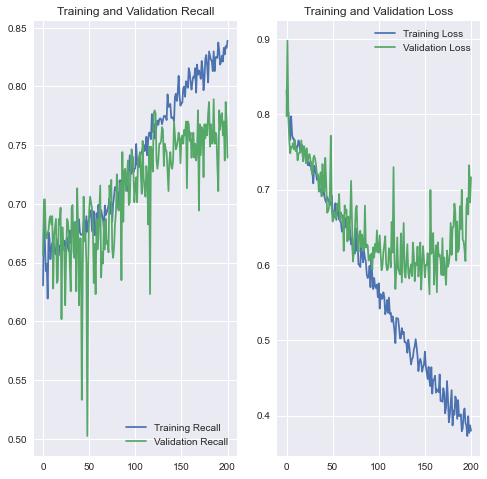

In [14]:
plt.style.use('seaborn')
acc = history.history['recall']
val_acc = history.history['val_recall']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Recall')
plt.plot(epochs_range, val_acc, label='Validation Recall')
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('graphs/simplemodel128x2aug_zoom.png', bbox_inches='tight')
plt.show()

In [15]:
test_generator = test_datagen.flow_from_directory(
        'plants/test',
        target_size=(300, 200),
        batch_size=16,
        shuffle=False,
        class_mode='categorical')

Found 424 images belonging to 3 classes.


In [16]:
ben_plants = os.listdir('plants/test/Benign_Plants')
ivy=os.listdir('plants/test/Poison_Ivy/')
oak=os.listdir('plants/test/Poison_Oak')

In [17]:
y_true=pd.DataFrame()
for i in range(len(ben_plants)):
    num=pd.Series([1,0,0])
    y_true= y_true.append(num, ignore_index=True)
for j in range(len(ivy)):
    num=pd.Series([0,1,0])
    y_true= y_true.append(num, ignore_index=True)
for k in range(len(oak)):
    num=pd.Series([0,0,1])
    y_true= y_true.append(num, ignore_index=True)

In [18]:
y_hat=(model.predict(test_generator, verbose=1))

27/27 [==============================] - 10s 354ms/step


In [19]:
y_pred=np.argmax(y_hat, axis=1)
y_s=np.argmax(np.array(y_true), axis=1)
c_mat=confusion_matrix(y_s, y_pred)
percent=(c_mat/(np.sum(c_mat, axis=1).reshape(3,-1))).reshape(3,3)

In [126]:
percent[0,0]

0.8729096989966555

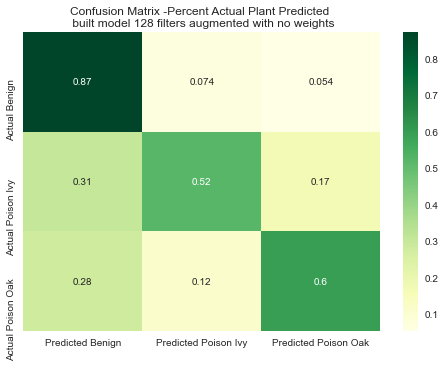

In [20]:
predicted_cat=['Predicted Benign', 'Predicted Poison Ivy', 'Predicted Poison Oak']
real_cat=['Actual Benign', 'Actual Poison Ivy', 'Actual Poison Oak']
sns.heatmap(percent, annot=percent, cmap='YlGn', 
            xticklabels=predicted_cat, 
            yticklabels=real_cat).set_title('Confusion Matrix -Percent Actual Plant Predicted \n built model 128 filters augmented with no weights');
plt.savefig('graphs/simplemodel128x2_2aug_zoom.png', bbox_inches='tight')

In [109]:
roc_benign_true=pd.Series(y_true[0])
roc_poison_true=pd.Series(y_true[1]+y_true[2])
roc_benign_hat=pd.Series(y_hat[:,0])
roc_poison_hat=pd.Series(y_hat[:,1]+y_hat[:,2])
roc_true=pd.DataFrame({'benign':roc_benign_true, 'poison':roc_poison_true})
roc_pred=pd.DataFrame({'benign':roc_benign_hat, 'poison':roc_poison_hat})

In [148]:
y_=pd.DataFrame(y_hat)
y_[0]=y_[0].apply(lambda x: x + 0.03)
y_
np.argmax(np.array(y_), axis=1)

array([1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 0, 2, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,

In [197]:
threshold_range=np.arange(-0.99, -0.33, 0.03)

In [163]:
y_true

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
419,0.0,0.0,1.0
420,0.0,0.0,1.0
421,0.0,0.0,1.0
422,0.0,0.0,1.0


In [193]:
def percent_change(y_true_, y_hat_, thresh):
    benign_percent=[]
    ivy_percent=[]
    oak_percent=[]
    y_true=y_true_
    for num in thresh:
        y_hat=pd.DataFrame(y_hat_)
        y_hat[0]=y_hat[0].apply(lambda x: x + num)
        y_pred=np.argmax(y_hat.values, axis=1)
        y_s=np.argmax(np.array(y_true), axis=1)
        c_mat=confusion_matrix(y_s, y_pred)
        percent=(c_mat/(np.sum(c_mat, axis=1).reshape(3,-1))).reshape(3,3)
        benign_percent.append(percent[0,0])
        ivy_percent.append(percent[1,1]+percent[1,2])
        oak_percent.append(percent[2,1]+percent[2,2])
    return benign_percent, ivy_percent, oak_percent

In [198]:
benign_percent, ivy_percent, oak_percent=percent_change(y_true, y_hat, threshold_range)

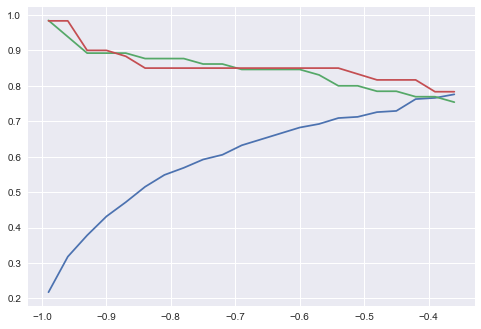

In [199]:
plt.plot(threshold_range, benign_percent)
plt.plot(threshold_range, ivy_percent)
plt.plot(threshold_range, oak_percent)

In [191]:
benign_percent

[0.0,
 0.431438127090301,
 0.5518394648829431,
 0.6287625418060201,
 0.6822742474916388,
 0.7157190635451505,
 0.7658862876254181,
 0.7959866220735786,
 0.8093645484949833,
 0.8394648829431438,
 0.8729096989966555,
 0.8896321070234113,
 0.903010033444816,
 0.919732441471572,
 0.9264214046822743,
 0.939799331103679,
 0.959866220735786,
 0.9632107023411371,
 0.9632107023411371,
 0.9732441471571907]

In [105]:
np.array(roc_pred.poison).shape

(424,)

In [23]:
loss=tf.keras.losses.CategoricalCrossentropy()

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [201]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 300, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 300, 200, 64)      9472      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 25, 128)       0

In [ ]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 7, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

In [207]:
variable=model.pop()

In [211]:
model.pop()

In [215]:
model.add(layers.Dropout(0.3)) 
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [219]:
len(model.layers)

13

NameError: name 'change_trainable_layers' is not defined

In [221]:
def change_trainable_layers(model, trainable_index):
    for layer in model.layers[:trainable_index]:
        layer.trainable = False
    for layer in model.layers[trainable_index:]:
        layer.trainable = True

In [225]:
change_trainable_layers(model, 10)

In [226]:
def print_model_properties(model, indices = 0):
     for i, layer in enumerate(model.layers[indices:]):
        print("Layer {} | Name: {} | Trainable: {}".format(i+indices, layer.name, layer.trainable))

In [227]:
print_model_properties(model, indices=0)

Layer 0 | Name: rescaling | Trainable: False
Layer 1 | Name: conv2d | Trainable: False
Layer 2 | Name: max_pooling2d | Trainable: False
Layer 3 | Name: conv2d_1 | Trainable: False
Layer 4 | Name: max_pooling2d_1 | Trainable: False
Layer 5 | Name: conv2d_2 | Trainable: False
Layer 6 | Name: max_pooling2d_2 | Trainable: False
Layer 7 | Name: conv2d_3 | Trainable: False
Layer 8 | Name: max_pooling2d_3 | Trainable: False
Layer 9 | Name: flatten | Trainable: False
Layer 10 | Name: dropout_1 | Trainable: True
Layer 11 | Name: dense_4 | Trainable: True
Layer 12 | Name: dense_5 | Trainable: True


In [ ]:
predicted_cat=['Predicted Benign', 'Predicted Poison Ivy', 'Predicted Poison Oak']
real_cat=['Actual Benign', 'Actual Poison Ivy', 'Actual Poison Oak']
sns.heatmap(percent, annot=percent, cmap='YlGn', 
            xticklabels=predicted_cat, 
            yticklabels=real_cat).set_title('Confusion Matrix -Percent Actual Plant Predicted \n How my Brain Decides');
plt.savefig('graphs/my_brain_matrix.png', bbox_inches='tight')